# Checking TIRL registration outputs in the BigMac dataset

### This notebook demonstrates how you can check the quality of the MRI-microscopy co-registration for any BigMac microscopy section.

### The MRI (either MGE structural image, or some other MRI image where transforming to dwi is demonstrated) will be mapped onto the microscopy plane, for comparison with the microscopy image

### Outputs are provided at either MRI resolution (0.3mm - equivalent to the structural MRI resolution at which the tirl warpfield is generated) or at high resolution i.e. ~40 micron pixels

In [1]:
# Libraries
import tirl
import numpy as np
from tirl import fsl
from tirl.timage import TImage
import os
import sys
import shutil
import cv2
import glob
from PIL import Image
import nibabel as nib
from matplotlib import pyplot as plt
%matplotlib inline
from tirl.interpolators.scipyinterpolator import ScipyNearestNeighbours


# Make sure you are using tirl_v2.1.3b1
!tirl version

2.1.3b1


In [2]:
def show_composite(struct_in_micro,hr):

    # show composite image - a checkerboard of the microscopy and warped mr image
    s1,s2 = struct_in_micro.shape
    hr = hr-hr.min()
    hr.normalise()
    struct_in_micro.normalise()
    composite = np.empty((s1,s2))
    gap=100
    for i in np.arange(0,s1,gap):
        for j in np.arange(0,s2,gap):
            m1 = np.min([s1,i+gap])
            m2 = np.min([s2,j+gap])
            if np.mod(i,2*gap)==np.mod(j,2*gap) :
                composite[i:m1,j:m2] = hr[i:m1,j:m2]
            else:
                composite[i:m1,j:m2] = struct_in_micro[i:m1,j:m2]

    fig = plt.imshow(composite,cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)


In [3]:
def mask_hr_image(micro,hr,fileparts):
    
    # Use high resolution mask for PLI images that were registered as a whole ('Full')
    if True in (ele == 'PLI' for ele in fileparts) and True in (ele == 'Full' for ele in fileparts):
        fmask = glob.glob(micro_timg.split('Reg2MRI')[0]+"/Masks/*")       
        mask_hr = TImage(fmask[0])
        # dilate mask so we can see tissue edges
        kernel = np.ones((5, 5), np.uint8)
        mask_hr = TImage(cv2.dilate(mask_hr.data,kernel,iterations=10))
        scale = np.array(micro.shape)/np.array(mask_hr.shape)
        mask_hr = mask_hr.resample(0.1)
        hr.mask = mask_hr.data
        # Also reshape to add to downsampled micro image
        mask = mask_hr.resample(scale[0],scale[1])
        micro.mask = mask.data
        
    # Otherwise can use mask included in micro 
    else:    
        # warp registration mask to hr domain and apply to hr image
        coords = micro.domain.map_physical_coordinates(hr.domain.get_physical_coordinates())
        mask = TImage(micro.mask)
        mask.interpolator = ScipyNearestNeighbours
        mask_hr = mask.interpolator(coords).reshape(hr.shape)
        # dilate mask so we can see tissue edges
        kernel = np.ones((5, 5), np.uint8)
        mask_hr = cv2.dilate(mask_hr,kernel,iterations=10)
        hr.mask = mask_hr
        
    # apply mask to both hr and downsampled image
    hr.apply_mask(hr.mask)
    micro.apply_mask(micro.mask)
    return micro, hr


def load_microscopy(micro_timg,hr_im,mask=True):
    
    # load microscopy warpfield. 
    # micro also includes a copy of the microcopy data at MR resolution
    micro = tirl.load(micro_timg)
    fileparts = micro_timg.split('/')
    
    # load hr image
    hr = TImage(hr_im)
    hr = hr.astype(np.float64)
    hr.reduce_tensors()    # if rgb, reduce to greyscale
    #if contrast == "PLI": # If loading the PLI data, downsample by factor of 10 to save computation time
    if True in (ele == 'PLI' for ele in fileparts):
        hr = hr.resample(0.1)
    # copy tranformations from tirl warpfield to high resolution image
    hr.domain.copy_transformations(micro.domain)
    # mask hr image according to registration mask
    if mask==True:
        micro,hr = mask_hr_image(micro,hr,fileparts)
    return micro, hr

### Define microscopy section of interest

In [4]:
# BigMac directory
ddir = "/vols/Data/km/ahoward/BigMac-clean/"

# Folder containing microscopy data and tirl warpfields
# High resolution microscopy image
# comment out PLI or gallyas
# PLI:
base = ddir + "/Microscopy/PLI/Anterior/P090x/"
hr_im = base+"/Inclination.tif"
contrast = 'PLI'
# Gallyas:
base = ddir + "/Microscopy/Gallyas/Anterior/H050x/H050a_structureTensor/"
hr_im = base+"RGB_thumb.tif"
contrast = 'Gallyas'

# timg containing information to transform microscopy to physical space 
# (i.e. tirl intemediary space) where the data are coregistered
# Do not change this
micro_timg = base + "/Reg2MRI/Full/slice.timg"

# timg containing information to transfrom mri to physical space
# Do not change this
mri_timg = base + "/Reg2MRI/Full/volume.timg"


### Map structural MRI onto microscopy plane

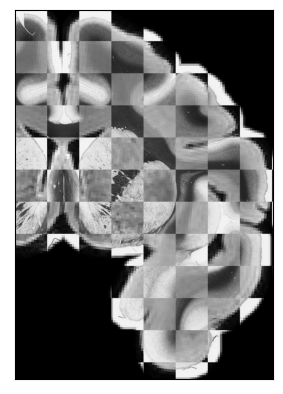

In [5]:
# 1. Load microscopy slide that we have registered to structural MRI space using TIRL
# Load both warpfield (timg: microscopy -> physical) and high resolution image
micro, hr = load_microscopy(micro_timg,hr_im)

# 2. Load volume.timg which contains structural image and warpfield from coordinate->voxel space
struct = tirl.load(mri_timg)


# 4. Map mri to microscopy plane 
# Add the following two lines to use nearet neihgbour interpolation (retains feeling for MRI resolution)
struct.interpolator = ScipyNearestNeighbours

# Option 4a. Map to downsampled microscopy space
struct_in_micro = struct.evaluate(micro.domain)
struct_in_micro.apply_mask(micro.mask)
# Save snapshot of output
if not os.path.isdir('./Coregistration'):
    os.mkdir('./Coregistration')
struct_in_micro.snapshot('./Coregistration/struct.tif',overwrite=True)

# Option 4b. Map to high resolution microscopy space (more computationally demanding & time consuming)
struct_in_hr = struct.evaluate(hr.domain)
struct_in_hr.apply_mask(hr.mask)
struct_in_hr.snapshot('./Coregistration/struct_hr.tif',overwrite=True)
show_composite(struct_in_hr,hr)


In [6]:
# Also copy microscopy image to this folder
micro.snapshot('./Coregistration/microscopy.tif',overwrite=True)
hr.snapshot('./Coregistration/microscopy_hr.tif',overwrite=True)

### Map other MR image (e.g dwi) onto microscopy plane

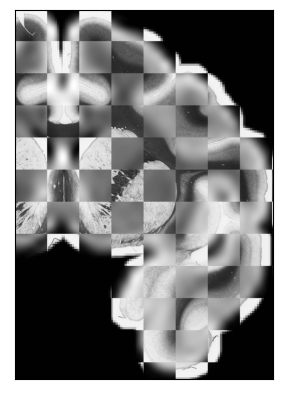

In [7]:
# 1. Load microscopy slide that we have registered to structural MRI space using TIRL
# Load both warpfield (timg: microscopy -> physical) and high resolution image
if not 'micro' in locals() or not 'hr' in locals():
    micro, hr = load_microscopy(micro_timg,hr_im)


# 2. Create warpfield from microscopy to structural
# (microscopy -> physical -> mri)

# copy chain
chain = micro.domain.chain.copy()

# Invert warpfield in mri_timg and add to warpfield from micro_timg 
struct = tirl.load(mri_timg)
tirl2struct = struct.domain.chain.inverse()
chain += tirl2struct


# 3. If mapping to some space other than the postmortem MGE structural, import 
# FNIRT transformation & add to transformation chain
# (microscopy -> physical -> structural -> mri of interest)
# Note, opposite transform to what you might expect due to how fsl defines warpfields (i.e dwi to struct not struct to dwi)
dwi = ddir + "/MRI/Postmortem/dwi/b10k/1.0mm/data/S0.nii.gz"
field = ddir + "/MRI/Postmortem/dwi/b10k/1.0mm/reg/dwi_1.0mm_2_struct_fnirt/dwi_1.0mm_2_struct_fnirt_field.nii.gz"
warp = fsl.load_warp(field, moving=dwi)


# Mapping with a flirt transform rather than a fnirt field
#dwi = ddir + "/MRI/Postmortem/dwi/b04k/0.6mm/data/S0.nii.gz"
#mat = "/vols/Data/km/ahoward/BigMac-clean/MRI/Postmortem/struct/MGE/reg/struct_2_dwi_0.6mm_flirt/struct_2_dwi_0.6mm_flirt.mat"
#ref = ddir + "/MRI/Postmortem/struct/MGE/data/struct.nii.gz"
#warp = fsl.load_mat(mat,input=ref,reference=dwi)

chain += warp

# 4. add chain to micro and hr images
micro.domain.chain = chain
hr.domain.chain = chain


# 5. Map mri to microscopy plane using nearest neighbour interpolation
# Load DWI image
mri = TImage(dwi)
# Add the following two lines to use nearet neihgbour interpolation (retains feeling for MRI resolution)
#mri.interpolator = ScipyNearestNeighbours

# Option 5a. Map to downsampled microscopy space
coords = micro.domain.map_voxel_coordinates(micro.domain.get_voxel_coordinates())
mri_in_micro = TImage(mri.interpolator(coords).reshape(micro.shape))
mri_in_micro.apply_mask(micro.mask)
mri_in_micro.snapshot('./Coregistration/mri.tif',overwrite=True)

# Option 5b. Map to high resolution microscopy space (more computationally demanding & time consuming)
coords = hr.domain.map_voxel_coordinates(hr.domain.get_voxel_coordinates())
mri_in_hr = TImage(mri.interpolator(coords).reshape(hr.shape))
mri_in_hr.apply_mask(hr.mask)
mri_in_hr.snapshot('./Coregistration/mri_hr.tif',overwrite=True)
show_composite(mri_in_hr,hr)


### The images in ./Coregistration/ can now be viewed using Fsleyes, ImageJ or other viewers, where the user can flick back and forth between the images to assess the quality of the registration

In [ ]:
!fsleyes ./Coregistration/microscopy_hr.tif ./Coregistration/struct_hr.tif ./Coregistration/mri_hr.tif 